#### data wrangling

In [1]:
# import packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv("https://media.githubusercontent.com/media/boneeyah/DS7331_Group/main/Data_Files/airbnb_los_angeles.csv")
#df = pd.read_csv("Data_Files/airbnb_los_angeles.csv")

In [2]:
# drop variables which won't be useful for the classification model
for col in [
    'listing_url','scrape_id','last_scraped','description','neighborhood_overview','picture_url','host_url','host_about','host_response_time','host_response_rate','host_acceptance_rate',
    'host_thumbnail_url','host_picture_url','host_verifications','host_has_profile_pic','bathroom_text','host_listings_count','host_neighbourhood','bathrooms','minimum_minimum_nights',
    'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','availability_30','availability_60',
    'availability_90','availability_365','calendar_last_scraped','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_accuracy','review_scores_communication','review_scores_cleanliness',
    'review_scores_checkin','review_scores_value','review_scores_location','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms','reviews_per_month','neighbourhood','neighbourhood_group_cleansed', 'first_review','last_review','minimum_nights','maximum_nights','license'
]:
    if col in df:
        del df[col]

In [3]:
# remove nulls
df = df[~df.review_scores_rating.isnull() & ~df.bathrooms_text.isnull() & ~df.host_since.isnull() & ~df.host_location.isnull()]

## getting property type from string
types = ['Private room', 'Entire', 'Room in hotel','Room','Shared room']
pat = '|'.join(r"\b{}\b".format(x) for x in types)

df['property_type']= df['property_type'].str.extract('('+ pat + ')', expand = False)
df['property_type'] = (df.property_type.
                       fillna(value = 'other').
                       replace(['Entire','Room in hotel'],['Entire unit','Hotel room']))
df['property_type'].value_counts()

Entire unit     22767
Private room     8081
Shared room       510
Room              401
other             298
Hotel room        272
Name: property_type, dtype: int64

In [4]:
# impute values based on median
df['beds'] = df[['accommodates','beds']].groupby(by = 'accommodates').transform(lambda grp: grp.fillna(grp.median()))
df_grouped = df.groupby(by = ['property_type','beds'])
df_imputed = df_grouped[['beds','bedrooms']].transform(lambda grp: grp.fillna(grp.median()))

index = df_imputed[df_imputed.bedrooms.isnull()].index
df = df.drop(index= index)

df['imputed']=df_imputed[['bedrooms']]

# replace 'bedrooms' column with imputed column and deleting the duplicated column
df['bedrooms'] = df['imputed']
del df['imputed']

In [5]:
## now fixing dtypes for attributes
df['host_since'] = pd.to_datetime(df.host_since)
df['price'] = df['price'].replace('[\$,]','',regex = True).astype(float)
df['bathrooms_text'] = df['bathrooms_text'].replace(['Half-bath', 'Shared half-bath', 'Private half-bath'],['0.5 bath','0.5 shared bath', '0.5 private bath'])
df_bathrooms = df['bathrooms_text'].str.split(n=1, expand=True).rename(columns = {0:'bathroom_number',1:'bathroom_type'})
df_bathrooms['bathroom_type'] = df_bathrooms.bathroom_type.fillna(value = 'bath')
df_bathrooms['bathroom_type'] = df_bathrooms['bathroom_type'].replace(['baths','shared baths'],['bath','shared bath'])
df_bathrooms['bathroom_number'] = df_bathrooms['bathroom_number'].astype('float')
df.insert(15, 'bathroom_number',df_bathrooms['bathroom_number'])
df.insert(16, 'bathroom_type', df_bathrooms['bathroom_type'])
del df['bathrooms_text']

In [6]:
### filter out price outliers
df = df[(df.beds<10) & (df.price<750)]

In [7]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              30580 non-null  int64         
 1   name                            30580 non-null  object        
 2   host_id                         30580 non-null  int64         
 3   host_name                       30580 non-null  object        
 4   host_since                      30580 non-null  datetime64[ns]
 5   host_location                   30580 non-null  object        
 6   host_is_superhost               30580 non-null  object        
 7   host_total_listings_count       30580 non-null  float64       
 8   host_identity_verified          30580 non-null  object        
 9   neighbourhood_cleansed          30580 non-null  object        
 10  latitude                        30580 non-null  float64       
 11  lo

In [8]:
# breakdown of categorical variables with number of levels (unique)
df.iloc[:,[1,3,5,6,8,9,12,13,16,19,21,24]].describe().T

,count,unique,top,freq
name,30580,29942,Boutique Hostel,46
host_name,30580,6604,David,249
host_location,30580,980,"Los Angeles, California, United States",10613
host_is_superhost,30580,2,f,20236
host_identity_verified,30580,2,t,26080
neighbourhood_cleansed,30580,302,Long Beach,1163
property_type,30580,6,Entire unit,21090
room_type,30580,4,Entire home/apt,21433
bathroom_type,30580,3,bath,22738
amenities,30580,28937,"[""Hangers"", ""First aid kit"", ""Heating"", ""Fire ...",40


# Create Models


### Rubric Note: Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use a 80/20 train/test split for your data). Adjust parameters of the model to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. THat is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. FOr many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

In [9]:
# Model will focus on classifying superhost status
# since we're encoding with binary response, we can use labelencoder from sklearn
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['host_is_superhost'] = label_encoder.fit_transform(df['host_is_superhost'])
df.host_is_superhost.value_counts()

0    20236
1    10344
Name: host_is_superhost, dtype: int64

In [10]:
## encoding binary categorical variables
# encode identity verified
df['host_identity_verified'] = label_encoder.fit_transform(df['host_identity_verified'])
df.host_identity_verified.value_counts()

#encode has_availability
df['has_availability'] = label_encoder.fit_transform(df['has_availability'])
df.has_availability.value_counts()

#encode instant bookable
df['instant_bookable'] = label_encoder.fit_transform(df['instant_bookable'])
df.instant_bookable.value_counts()

0    19767
1    10813
Name: instant_bookable, dtype: int64

In [11]:
## changing host_location to a binary feature of is_local using a list of LA area neighborhoods that will be used to extract from location str
#los_angeles = pd.read_csv('Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = pd.read_csv('https://raw.githubusercontent.com/boneeyah/DS7331_Group/main/Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = los_angeles.iloc[:,0].tolist()

pattern = '|'.join(los_angeles)
df['host_is_local'] = df['host_location'].str.contains(pattern)

df['host_is_local'] = label_encoder.fit_transform(df['host_is_local'])


In [12]:
## changing host_since to host_for to get a a numerical variable that corresponds to length in months
## data is from June 6 2022, 06-06-2022
end_date = pd.to_datetime('06-06-2022', format= "%m-%d-%Y")
df['host_for'] = (end_date-df.host_since)/np.timedelta64(1,'M')

df = df.drop(columns= ['host_location', 'host_since']) #drop old host_location and host_since columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              30580 non-null  int64  
 1   name                            30580 non-null  object 
 2   host_id                         30580 non-null  int64  
 3   host_name                       30580 non-null  object 
 4   host_is_superhost               30580 non-null  int32  
 5   host_total_listings_count       30580 non-null  float64
 6   host_identity_verified          30580 non-null  int32  
 7   neighbourhood_cleansed          30580 non-null  object 
 8   latitude                        30580 non-null  float64
 9   longitude                       30580 non-null  float64
 10  property_type                   30580 non-null  object 
 11  room_type                       30580 non-null  object 
 12  accommodates                    

In [13]:
# One Hot Encoding other categorical variables as a non-sparse dataframe
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

df_temp = df[['id','neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']] # to get only the cat variables


In [14]:
ohe = OneHotEncoder(drop='first',sparse=False)
feature_arr = ohe.fit_transform(df_temp[['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']])
feature_labels = ohe.get_feature_names_out()

#create dataframe with features
df_temp = pd.DataFrame(feature_arr, columns= feature_labels)

In [15]:
# drop original columns and join with new onehotencoded columns
df = df.drop(columns = ['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type','amenities','name','host_name','id','host_id','latitude','longitude']).join(df_temp)


In [16]:
### different method I found first, commented out for now, this could be used to transform within the original dataset saving one step
### but it's easy enough to just fit a new dataframe and then add to original and drop original columns instead
#transformer = make_column_transformer((OneHotEncoder(drop = 'first',sparse=False), ['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']), remainder='passthrough')
#df_temp = transformer.fit_transform(df_temp)
#df_temp = pd.DataFrame(df_temp, columns=transformer.get_feature_names_out())
#print(df_temp)

In [17]:
### clean up temporary files
del df_temp, feature_arr, feature_labels

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 326 entries, host_is_superhost to bathroom_type_shared bath
dtypes: float64(318), int32(4), int64(4)
memory usage: 75.6 MB


### Logistic Regression Model

In [19]:
### performing 80/20 split using sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix

cutoff = .63
seed = [10,2,2022] #seed to be used, it will be assigned as random_state when splitting instead of using np to set seed

#dividing dataset into features and labels
X = df.loc[:,df.columns != 'host_is_superhost']
X_sc = StandardScaler().fit_transform(X) #scaled X values
y = df.loc[:, df.columns == 'host_is_superhost']
iter_num =0
for i in seed:
    X_train, X_test, y_train, y_test = train_test_split(X_sc,y, random_state=i, train_size=.8, shuffle=True) #X_train is scaled since X_sc is used for X
    lor_clf = LogisticRegressionCV(cv=10, max_iter = 300, random_state = i)
    lor_clf.fit(X_train, y_train.values.ravel())

    y_hat = lor_clf.predict_proba(X_test)


    response = pd.DataFrame(y_hat, columns=['F','T'])
    y_preds=(response['T']>cutoff).astype('int')

    cm = confusion_matrix(y_test,y_preds)
    print('---------Iteration  ',iter_num,'---------')
    print('Confusion Matrix')
    print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
    print('________________________________')
    print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
    print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
    print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')
    iter_num=iter_num+1

---------Iteration   0 ---------
Confusion Matrix
       True  False
True   3915    179
False  1555    467
________________________________
accuracy: 0.7164813603662524
sensitivity: 0.7157221206581352
specificity: 0.7229102167182663 

---------Iteration   1 ---------
Confusion Matrix
       True  False
True   3911    156
False  1572    477
________________________________
accuracy: 0.7174623937213865
sensitivity: 0.7132956410724056
specificity: 0.7535545023696683 

---------Iteration   2 ---------
Confusion Matrix
       True  False
True   3935    154
False  1558    469
________________________________
accuracy: 0.7200784826684107
sensitivity: 0.7163662843619152
specificity: 0.7528089887640449 



### Support Vector Machine Model

X_sc was scaled using the standard scalar package from sklearn during Logistic Regression and still exists for our use in the SVM Model.

In [20]:

from sklearn.svm import SVC
from sklearn import metrics as mt
X_train, X_test, y_train, y_test = train_test_split(X_sc,y, random_state=i, train_size=.8, shuffle=True)#X_test/train is scaled since X_sc is used for X
    
svm_clf = SVC(C=0.5,kernel='rbf',degree =3, gamma='auto', random_state=2)
svm_clf.fit(X_train,y_train.values.ravel())

y_hat = svm_clf.predict(X_test)
acc = mt.accuracy_score(y_test,y_hat)
cm = mt.confusion_matrix(y_test,y_hat)
print('Confusion Matrix')
print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
print('________________________________')
print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')

Confusion Matrix
       True  False
True   3780    309
False  1459    568
________________________________
accuracy: 0.7109221713538261
sensitivity: 0.7215117388814659
specificity: 0.6476624857468644 



In [ ]:
y_hat

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
#### this works for now, but the data is not balanced since there are fewer superhosts than not. running predict_proba is much slower.


seed = [10,2,2022] # same set of seeds for same splits
cutoff = .63 # same as before
iter_num =0
for i in seed:
    X_train, X_test, y_train, y_test = train_test_split(X_sc,y, random_state=i, train_size=.8, shuffle=True)
    
    svm_clf = SVC(C=0.5,kernel='rbf',degree =3, gamma='auto',random_state=i,class_weight='balanced')
    svm_clf.fit(X_train,y_train.values.ravel())
    
    y_hat = svm_clf.predict(X_test)
    
    response = pd.DataFrame(y_hat, columns=['pred'])
    y_preds=(response['pred'])
    
    cm = confusion_matrix(y_test,y_preds)
    print('---------Iteration  ',iter_num,'---------')
    print('Confusion Matrix')
    print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
    print('________________________________')
    print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
    print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
    print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')
    iter_num=iter_num+1
    

---------Iteration   0 ---------
Confusion Matrix
       True  False
True   2448   1646
False   521   1501
________________________________
accuracy: 0.64568345323741
sensitivity: 0.824520040417649
specificity: 0.47696218620908803 

---------Iteration   1 ---------
Confusion Matrix
       True  False
True   2403   1664
False   492   1557
________________________________
accuracy: 0.6474820143884892
sensitivity: 0.8300518134715026
specificity: 0.4833902514746973 

---------Iteration   2 ---------
Confusion Matrix
       True  False
True   2416   1673
False   481   1546
________________________________
accuracy: 0.6478090255068673
sensitivity: 0.8339661719019675
specificity: 0.48027337682510096 



# Model Advantages

### Rubric Note: Discuss the advantages of each model for each classifciation task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficience? Explain in detail.

# Interpret Feature Importance

### Rubric Note: Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. WHy do you think some variables are more important?

In [19]:
# coefficient corresponds to the weights, since the data has been scaled (larger absolute values are features of most importance)
importance = pd.DataFrame(lor_clf.coef_.transpose(),index= X.columns.values.tolist(), columns= ['coefficient']).sort_values(ascending=False, by = 'coefficient')
importance = importance[(importance['coefficient']<-.2) | (importance['coefficient']>.2)] # since we have so many variables, this takes the most important
importance

,coefficient
review_scores_rating,1.766198
has_availability,1.135527
calculated_host_listings_count,0.897888
property_type_Private room,0.530965
number_of_reviews,0.502871
neighbourhood_cleansed_Long Beach,0.270513
neighbourhood_cleansed_Santa Ana,0.269102
neighbourhood_cleansed_La Mirada,0.239152
neighbourhood_cleansed_Venice,0.232512
neighbourhood_cleansed_Santa Monica,0.230124


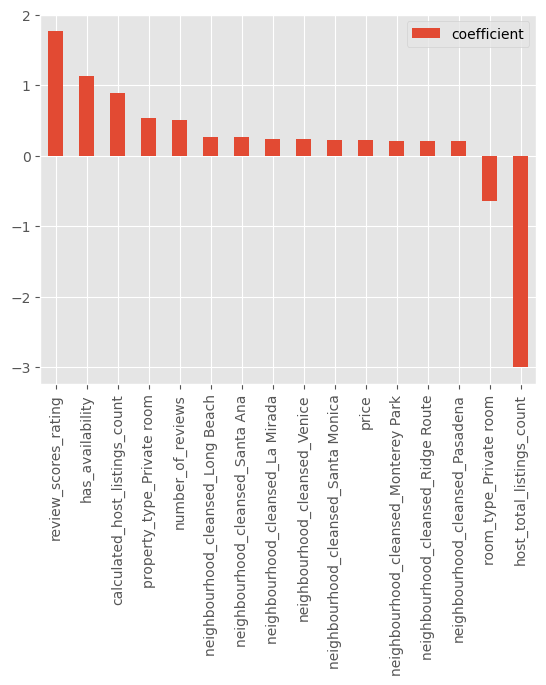

In [20]:
## feature importance for select features, (16 features with the highest positive and negative coefficients)
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = importance.plot(kind='bar')
plt.show()

# Interpret Support Vectors

### Rubric Note: Look at the chosen support vectors for the classfication task. Do these provide any 8insight into the data? Explain. IF you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model - then analyze the support vectors from the subsampled dataset.